In [1]:
#import the libararies
#!pip install xgboost
#!pip install nltk
#!pip install matplotlib
!pip install seaborn
from xgboost import XGBRegressor
import pandas as pd 
from sklearn.metrics import r2_score
import re
import math
from nltk.stem.snowball import SnowballStemmer
import nltk
import  matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
# set up the stopwords set for steaming and 
stop_words=set(stopwords.words('english'))
stop_words.add('none')
# initilize the object of steammer
stemmer = SnowballStemmer("english")

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\x2125\\anaconda3\\lib\\site-packages\\pandas-1.5.3.dist-info\\METADATA'



In [6]:
#import the csv to panda dataframe
data=pd.read_csv(r'C:\Users\x2125\Desktop\full.csv')
data.head()

C:\Users\x2125\AppData\Local\Temp\ipykernel_21996\1565745319.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(r'C:\Users\x2125\Desktop\full.csv')


,reward,id,name,description,dao,creat,creator,audit_log,due_date,assignees,priority,status,tags,review,rewards,done,comments,subtasks
0,NaN,004eb852-4e15-4766-a190-82912dfe0241,Introduce yourself in the community,We want to get to know the community! Stop by ...,cohere,2022-04-27T21:56:05.911Z,marcvs,[{'id': '37dd1b58-9748-4edd-8b06-0564fe43fb06'...,NaN,NaN,NONE,TODO,'community',NaN,NaN,NaN,none,"introduce yourself in the community, , introd..."
1,NaN,00b3cc91-9648-4b41-b666-27e54e17ba0e,ParaSwap,Self integrate into Dex Lib\n\n\\n,airswap,2022-11-14T20:06:50.349Z,xtra,[{'id': 'ea308758-3e2a-40d9-bd67-0a406f1ccc24'...,NaN,NaN,HIGH,IN_PROGRESS,'aggregator',NaN,NaN,NaN,"'draysongz working on it.', 'mitsi and whatday...","rfq (signer side), , rfq (both sides), , last..."
2,NaN,0114cf53-f1e9-4041-beec-9211d2b10995,Subscriptions,**Google Workspace (GSuite)**\n\n**Miro**\n\n*...,sourcecred,2022-03-22T23:27:11.705Z,ALOYSIOUS,[],2022-04-30T23:43:36.718Z,ALOYSIOUS,NONE,IN_PROGRESS,"'subscriptions', 'treasury', 'aloysious'",NaN,NaN,NaN,none,"contact cardholders // thena, reyder, dandeli..."
3,NaN,018247fc-4a06-4425-8082-0e69c82f0052,Parcel 0 NFT Reveal (CIP-112 Retroactive comp ...,For details: See **FUNDING section at** <https...,citydao,2022-09-07T23:34:48.694Z,Tuncay,[{'id': 'f4aae912-c2a8-46b4-99c4-3ce839060989'...,NaN,reeves|Tuncay|Mayur Mistry|sdsr|DenverCitizen9...,NONE,DONE,NaN,NaN,NaN,2022-09-07T23:47:25.305Z,none,[cip-112] parcel 0 nft reveal retroactive com...
4,NaN,0217a1e7-8820-4393-83cc-2ac02587a101,💰3-21-book-club,- [Discord Link](https://discord.com/channels/...,poapathon,2022-03-28T11:02:27.095Z,ribbs.eth,[],NaN,NaN,NONE,DONE,"'poap', 'confirmed', 'double-checked', 'first ...",NaN,NaN,2022-04-09T00:58:22.248Z,none,second place 💰 professional development book ...


In [7]:
#drop the rewards column which is non-standadized
data=data.drop(columns=['rewards'],axis=1)
#checking missing_values 
data.isna().sum()

reward         28448
id                 0
name               3
description     7541
dao                0
creat              0
creator            0
audit_log          0
due_date       30389
assignees      14570
priority           0
status             0
tags           15647
review         35116
done           17058
comments         128
subtasks       31086
dtype: int64

In [8]:
#drop the rows containing missing reward
data=data.dropna(subset=['reward'])
#describe the reward 
data[['reward']].describe()

,reward
count,7565.000000
mean,203.296785
std,572.271405
min,0.000000
25%,0.295200
50%,0.999800
75%,1.000000
max,1850.530000


In [9]:
#data validation 
# keep only those instances which have the reward>0
data=data[data['reward']>0]
##keep only those with the status of done, todo, in_review, or in_progress
data=data[data['status'].isin(['DONE','TODO','IN_REVIEW','IN_PROGESS'])]
#check missing valus again 
data.isna().sum()

reward            0
id                0
name              1
description    1603
dao               0
creat             0
creator           0
audit_log         0
due_date       5135
assignees       599
priority          0
status            0
tags           3903
review         6790
done            646
comments         35
subtasks       6495
dtype: int64

<Axes: >

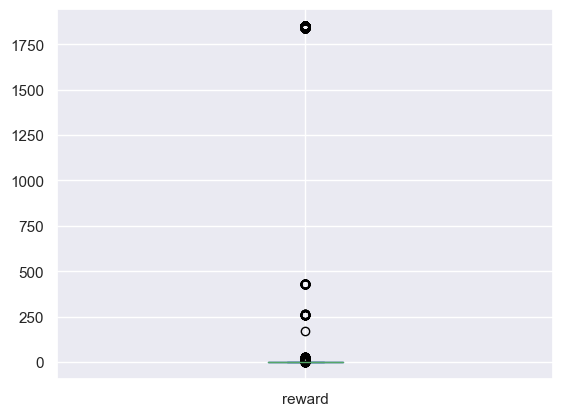

In [10]:
# now some EDA for reward, the first comes as the boxplot
data['reward'].plot.box()



<Axes: ylabel='Frequency'>

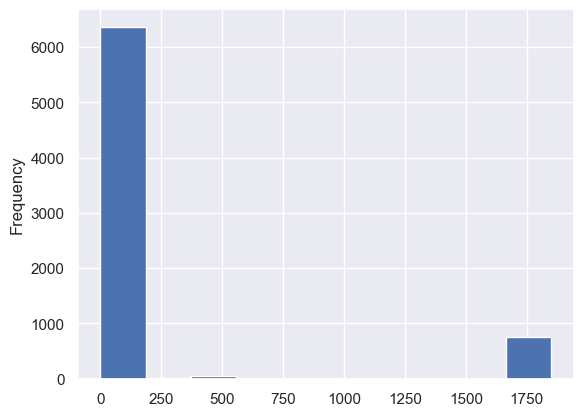

In [11]:
# the second the hist plot, so the data is skewed, and it does not follow the distribution
data['reward'].plot.hist()

In [12]:
data['description']=data['description'].fillna('None')
data['description']

6        Mocks:\n\n[https://www.figma.com/file/snsXfRjY...
28       Based on article/podcast about:\n\n* How to bu...
45       # Responsibilities\n\n* managing the Discord b...
55       Write engaged threads to expand Paladin Commun...
70       ## # Context\n\nIn order to support and promot...
                               ...                        
35823                                                 None
35838                                                 None
35846      ![image.png](https://storage.googleapis.com/...
35901    Right now our invite links are like "/o/<orgid...
35976    Requirements:\n- When clicking on the three do...
Name: description, Length: 7196, dtype: object

In [14]:
# next is to use the bag-of-words model to extrat the text features from the description 
# first is to remove punctuations, emojis, urls from descriptions
import re
def cleaning(text):
     # remove all non-digits and other characters
     text=re.sub('[^a-zA-Z ]','',text)
     # remove the HTTP string
     text=re.sub('(https\S+)','',text)
     text=re.sub('\s\s+','',text)
     return text
data.description=data['description'].apply(cleaning)
     
     


In [15]:
data['description'].values

array(['Mocks Sorting Top ContributorsTop Reviewers should be sorted by Tasks CompletedTasks reviewed by default It should also be possible to manually change sorting to Task points by clicking the column name All Contributors should show contributors which highest number of roles first nice to have Should be possible to sort All contributors by Joined at column Time period It should be possible to change time period by clicking buttons top right The default time period should be d Clicking the last button calendar icon should open calendar picker to choose a custom time period Export as CSV Only DAO admins should be able to export as CSV Make it possible to export alltables as CSV When exporting as CSV should export data for the selected time periodsorting Columns to include include all columns already in the tablea wallet address column Data display If task point or tasks completedreviewedshowinstead ofTechnical approach Atm we dont have a way to query filteredpaginated cards This is

In [16]:
# how many of the descriptions are none
data[data['description']=='None'].index

Index([  242,   299,   386,   608,   614,   746,   760,   840,   910,   963,
       ...
       34979, 34993, 35005, 35321, 35447, 35490, 35515, 35595, 35823, 35838],
      dtype='int64', length=1603)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer



In [19]:
data.columns

Index(['reward', 'id', 'name', 'description', 'dao', 'creat', 'creator',
       'audit_log', 'due_date', 'assignees', 'priority', 'status', 'tags',
       'review', 'done', 'comments', 'subtasks'],
      dtype='object')

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
target=data[['reward']]
variables=data.drop(columns=['reward'])
X_train,X_test,y_train,y_test=train_test_split(variables,target)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
preprocessor=ColumnTransformer([('drop_columns','drop',['id','name','audit_log','subtasks','tags','review','comments','assignees','creator']),('OneHot',OneHotEncoder(handle_unknown='ignore'),['dao','priority','status']),('vect', TfidfVectorizer(stop_words=list(stop_words),min_df=300),'description')])

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import tree
from sklearn import tree
from sklearn import ensemble
#params = {
    #"regressor__n_estimators": #[100,200,300,400,500],
    #"regressor__max_depth": #[4,5,6,7,8,9,10],
    #"regressor__min_samples_split": #[1,2,3,4,5,6],
    #"regressor__learning_rate": #[0.1,0.2,0.3,0.4,0.5,0.01,0.02],
    #"regressor__loss": #["squared_error"],
#}
random_state=0
clf_random_forest = Pipeline(
    steps=[("preprocessor", preprocessor),('regressor',RandomForestRegressor(random_state=random_state,max_depth=500,n_estimators=600))])
#clf=Pipeline(steps=[('preprocessor',preprocessor),('regressor', ensemble.GradientBoostingRegressor())])
#parameters_grid={'regressor__max_depth':[int(i/100) for i in range(1000,20000,1000)],'regressor__n_estimators':[int(i/10) for i in range(100,1000,100)]}
#search=GridSearchCV(clf,param_grid=params,verbose=2)
#search.fit(X_train,y_train)
#search.fit(X_train,y_train)
clf_random_forest.fit(X_train,y_train)

c:\Users\x2125\Desktop\Wonders\wonders\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['id', 'name', 'audit_log',
                                                   'subtasks', 'tags', 'review',
                                                   'comments', 'assignees',
                                                   'creator']),
                                                 ('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['dao', 'priority',
                                                   'status']),
                                                 ('vect',
                                                  TfidfVectorizer(min_df=300,
                                                                  stop_words=['during',
                                                                              'very',
                                                                              "weren't",
                                                                              'can',
                                                                              'y',
                                                                              'myself',
                                                                              'above',
                                                                              'have',
                                                                              'am',
                                                                              'isn',
                                                                              'which',
                                                                              'other',
                                                                              'than',
                                                                              'yourself',
                                                                              'while',
                                                                              'under',
                                                                              'when',
                                                                              'with',
                                                                              'most',
                                                                              "aren't",
                                                                              'but',
                                                                              'this',
                                                                              'her',
                                                                              'has',
                                                                              'both',
                                                                              'once',
                                                                              'you',
                                                                              'out',
                                                                              'having',
                                                                              "shouldn't", ...]),
                                                  'description')])),
                ('regressor',
                 RandomForestRegressor(max_depth=500, n_estimators=600,
                                       random_state=0))])

In [24]:
print("model score: %.3f" % clf_random_forest.score(X_test, y_test))

model score: 0.881


In [25]:
clf_boosting_regressor=Pipeline(steps=[('preprocessor',preprocessor),('regressor',GradientBoostingRegressor(learning_rate=0.1,loss='squared_error',max_depth=4,min_samples_split=2,n_estimators=200))])
clf_boosting_regressor.fit(X_train,y_train)
clf_boosting_regressor.score(X_test,y_test)


c:\Users\x2125\Desktop\Wonders\wonders\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.872181538473682

In [26]:
clf_ridge=Pipeline(steps=[('preprocessor',preprocessor),('regressor',linear_model.Ridge())])
clf_ridge.fit(X_train,y_train)
clf_ridge.score(X_test,y_test)

0.8410863686580904

In [36]:
from sklearn.neighbors import KNeighborsRegressor
clf_k_neighbor=Pipeline(steps=[('preprocessor',preprocessor),('regressor',KNeighborsRegressor(n_neighbors=3))])
clf_k_neighbor.fit(X_train,y_train)
clf_k_neighbor.score(X_test,y_test)

0.81039457713411

In [37]:
import xgboost as xgb
clf_xgboost=Pipeline(steps=[('preprocessor',preprocessor),('regressor',xgb.XGBRegressor(max_depth=100, objective='reg:squarederror'))])
clf_xgboost.fit(X_train,y_train)
clf_xgboost.score(X_test,y_test)

0.8742828387062153

In [29]:
from sklearn.tree import export_graphviz
from matplotlib import pyplot as plt
tree.plot_tree(clf.named_steps['regressor'],max_depth=6,fontsize=6)
plt.show()

NameError: name 'clf' is not defined

In [38]:
from sklearn.ensemble import StackingRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
estimators = [
    ("Random Forest", clf_random_forest),
    ("ridge", clf_ridge),
    ("Gradient Boosting", clf_boosting_regressor),
    ('k_neighbor',clf_k_neighbor),
    ('xgb',clf_xgboost)

]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=linear_model.RidgeCV(),cv='prefit')
stacking_regressor.fit(X_train,y_train).score(X_test,y_test)

c:\Users\x2125\Desktop\Wonders\wonders\Lib\site-packages\sklearn\ensemble\_stacking.py:955: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8742826634647805

In [39]:
example=X_test[X_test['id']=='7c57400a-66f4-4694-a82f-31bbad16372e']

In [45]:
example

,id,name,description,dao,creat,creator,audit_log,due_date,assignees,priority,status,tags,review,done,comments,subtasks


In [40]:
X_test.iloc[0,].values

array(['abb52ddc-dc69-455f-abdc-276d2bcfcf8e', 'Kevin May 1st', 'k',
       'boot finance dao', '2022-05-01T16:41:20.217Z', 'Sabretooth',
       "[{'id': 'e6c2f67e-1789-44f1-8e77-e33cb3146826', 'createdAt': '2022-05-01T16:41:20.362Z', 'user': {'id': '5b15eecc-5c85-4486-a935-83cab456c049', 'username': 'Sabretooth', 'imageUrl': 'https://cdn.discordapp.com/avatars/517267011861086208/c5de6ae5cca36b4d3f5a87869e9cddaa.jpg', 'permalink': 'https://app.dework.xyz/profile/Sabretooth', 'nodeId': 'c95d4ac6-a54d-42f3-86e1-524ffde51107', '__typename': 'User'}, 'sessionId': None, 'diff': [{'kind': 'N', 'rhs': {'status': 'TODO'}}], '__typename': 'AuditLogEvent'}, {'id': '8f10151e-6bea-4522-8d24-9f26ca6a2652', 'createdAt': '2022-05-01T16:42:26.801Z', 'user': {'id': '5b15eecc-5c85-4486-a935-83cab456c049', 'username': 'Sabretooth', 'imageUrl': 'https://cdn.discordapp.com/avatars/517267011861086208/c5de6ae5cca36b4d3f5a87869e9cddaa.jpg', 'permalink': 'https://app.dework.xyz/profile/Sabretooth', 'nodeId': '

In [42]:
import sklearn
sklearn.__version__


'1.3.0'

In [ ]:
stacking_regressor.predict(example)


In [46]:
import pickle
with open('trained_pipeline_0.01.pkl','wb') as f:
           pickle.dump(stacking_regressor,f)

In [49]:

model=pickle.load(open(r'C:\Users\x2125\Desktop\Wonders\WonderProject\api\model\trained_pipeline_0.01.pkl','rb'))

In [47]:
!pip freeze > requirements.txt

In [48]:
import sklearn
sklearn.__version__

'1.3.0'

In [ ]:
token_data = schemas.TokenData(username=username)

In [50]:
data['id']

6        0312b578-1626-4d28-b8e4-ab43bd8df160
28       14af35e9-cd39-4d46-afde-61e32cb1ae4d
45       1ca65f9b-1af1-4aeb-be43-d4f545ef0db1
55       2318c3ce-2135-4e48-96b8-6e740e2c5c9e
70       38053880-c180-46db-b03c-9502e1236749
                         ...                 
35823    27d02882-8a21-49c2-9d3f-a774cd1cd8a8
35838    fa5f31e6-8a8a-4a4b-b19a-21974cf8ee93
35846    4bf78f82-44f7-4468-9766-73f14a9cf47e
35901    bf579b5e-de35-4dab-920b-47e21d85b648
35976    379361e3-c17c-4130-a80e-fbcfa62671fd
Name: id, Length: 7196, dtype: object